# Version datasets in model training runs

## Introduction

* Keep track of a dataset version in your model training runs with artifacts  
* Query the dataset version from previous runs to make sure you are training on the same dataset version
* Group your Neptune Runs by the dataset version they were trained on




## Install Neptune and dependencies

In [ ]:
! pip install neptune-client scikit-learn==0.24.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 318 kB 7.6 MB/s 
     |████████████████████████████████| 22.3 MB 1.1 MB/s 
     |████████████████████████████████| 829 kB 43.8 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 181 kB 55.7 MB/s 
     |████████████████████████████████| 132 kB 54.7 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 8.9 MB 40.7 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 138 kB 63.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 59.8 MB/s 
     |████████████████████████████████| 130 kB 60.6 MB/s 
     |████████████████████████████████| 67 kB 6.4 MB/s 
     |████████████████████████████████| 80 kB 9.5 MB/s 
     |████████████████████████████████| 80 k

## Prepare a model training script

Create a training script where you:
* Specify dataset paths for training and testing
* Define model parameters
* Calculate the score on the test set

In [ ]:
# general packages
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

# imbelearn package
from imblearn.over_sampling import SMOTE

In [ ]:
import neptune.new as neptune

run = neptune.init(
    project="mlops/mlops",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzYzg3NDA4MS1iNGM1LTRmYzQtYmMyYy1lYjUyZmZhZjg1NTMifQ==",

)  # your credentials


https://app.neptune.ai/mlops/mlops/e/MLOP-49


Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive")
!ls

clean_data.csv	     clean_data_train.csv  dirty_data_test.csv
clean_data_test.csv  dirty_data.csv	   dirty_data_train.csv


### Load dirty dataset and EDA


In [ ]:
dirty_data = pd.read_csv('/content/drive/MyDrive/dirty_data.csv')

In [ ]:
dirty_data = dirty_data.drop(columns = ["customerID","Unnamed: 0"])

In [ ]:
pd.concat([dirty_data.isna().sum(),dirty_data.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
gender,300,2
SeniorCitizen,0,2
Partner,300,2
Dependents,0,2
tenure,0,74
PhoneService,0,2
MultipleLines,0,3
InternetService,0,3
OnlineSecurity,0,3
OnlineBackup,0,3


In [ ]:
dirty_data = dirty_data.fillna(dirty_data.median())

In [ ]:
pd.concat([dirty_data.isna().sum(),dirty_data.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
gender,0,2
SeniorCitizen,0,2
Partner,0,2
Dependents,0,2
tenure,0,74
PhoneService,0,2
MultipleLines,0,3
InternetService,0,3
OnlineSecurity,0,3
OnlineBackup,0,3


0    5174
1    1869
Name: Churn, dtype: int64


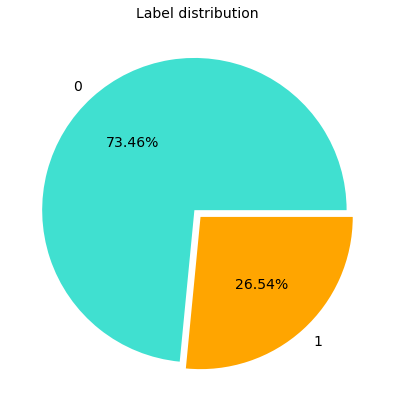

In [ ]:
## view target variable
print(dirty_data['Churn'].value_counts())

pie, ax = plt.subplots(figsize=[10,7])
labels = ['0', '1']
colors = ['turquoise', 'orange']
plt.pie(x = dirty_data['Churn'].value_counts()
        , autopct='%.2f%%', labels=labels, colors = colors, textprops={'fontsize': 14}, explode=[0.03]*2)
plt.title('Label distribution',fontsize=14)
plt.show()

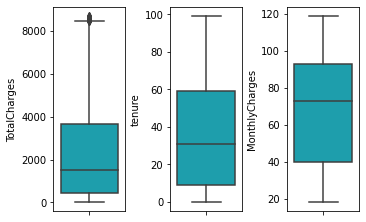

In [ ]:
# dt_vis dataframe contains 3 numerical columns that are in types of "int" and "float". 

dt_vis = dirty_data[['TotalCharges',
'tenure',
'MonthlyCharges']]

# Layout the whisker plots of the distribution of all 20 numerical variables. 

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(5, 3))
index = 0
axs = axs.flatten()
for k,v in dt_vis.items():
    sns.boxplot(y=k, data=dt_vis, ax=axs[index],color = '#06b1c4')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

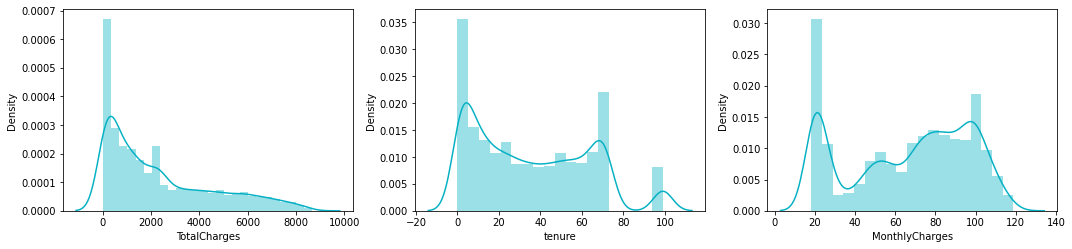

In [ ]:
# Layout the histograms and curves of the distribution of 3 numerical variables. 

plt.figure(figsize=(15,20))

col = ['TotalCharges',
'tenure',
'MonthlyCharges']

a = 1
for i in range(len(col)):
    plt.subplot(6, 3, a); 
    sns.distplot(dt_vis[col[i]], color = '#06b1c4')
    plt.xlabel(col[i])
    a += 1

plt.tight_layout()

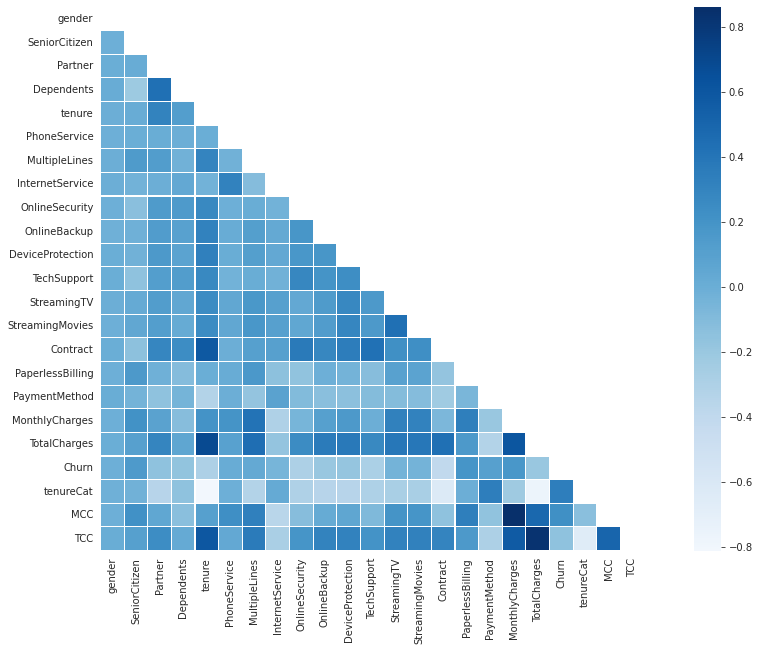

In [ ]:
## visualize the correlation 
corr = dirty_data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap="Blues", center=0, linewidths=0.1, square=True)

### Dirty dataset Modeling 

In [ ]:
## split the dirty dataset
dirty_data_train = dirty_data[:int(0.8*len(dirty_data))]
dirty_data_test = dirty_data[int(0.8*len(dirty_data)):]
dirty_data_train.to_csv("dirty_data_train.csv")
dirty_data_test.to_csv("dirty_data_test.csv")

In [ ]:
dirty_data_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'tenureCat', 'MCC', 'TCC'],
      dtype='object')

In [ ]:

TRAIN_DIRTY_DATASET_PATH = "/content/drive/MyDrive/dirty_data_train.csv"
TEST_DIRTY_DATASET_PATH = "/content/drive/MyDrive/dirty_data_test.csv"

def train_model(params, train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    FEATURE_COLUMNS = [ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges','tenureCat',
       'MCC', 'TCC']
    TARGET_COLUMN = ["Churn"]
    X_train, y_train = train[FEATURE_COLUMNS], train[TARGET_COLUMN]
    X_test, y_test = test[FEATURE_COLUMNS], test[TARGET_COLUMN]

    rf = RandomForestClassifier(**params)
    model = rf.fit(X_train, y_train)
    res = model.predict(X_test)

    return classification_report(y_test,res, output_dict=True)

In [ ]:
run["datasets/train"].track_files(TRAIN_DIRTY_DATASET_PATH)
run["datasets/test"].track_files(TEST_DIRTY_DATASET_PATH)

In [ ]:
#run["dirty_datasets"].track_files(DATASET_FOLDER)

NameError: ignored

## Run model training and log parameters and metrics to Neptune

In [ ]:
params = {
    "n_estimators": 3,
    "max_depth": 5,
    "max_features": 7,
}
run["parameters"] = params

In [ ]:
score = train_model(params, TRAIN_DIRTY_DATASET_PATH, TEST_DIRTY_DATASET_PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
score

{'0': {'f1-score': 0.8667279411764706,
  'precision': 0.8214285714285714,
  'recall': 0.9173151750972762,
  'support': 1028},
 '1': {'f1-score': 0.5482866043613707,
  'precision': 0.6743295019157088,
  'recall': 0.46194225721784776,
  'support': 381},
 'accuracy': 0.794180269694819,
 'macro avg': {'f1-score': 0.7075072727689207,
  'precision': 0.7478790366721402,
  'recall': 0.689628716157562,
  'support': 1409},
 'weighted avg': {'f1-score': 0.780619957268342,
  'precision': 0.781652314874703,
  'recall': 0.794180269694819,
  'support': 1409}}

In [ ]:
run["metrics/accuracy"] = score["accuracy"]

In [ ]:
run["metrics/recall"] = score["macro avg"]["recall"]

In [ ]:
run["metrics/f1-score"] = score["macro avg"]["f1-score"]

Get the run ID of your model training from Neptune. 

In [ ]:
baseline_run_id = run["sys/id"].fetch()
print(baseline_run_id)

MLOP-49


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/mlops/mlops/e/MLOP-49


## Clean dataset new run

In [ ]:
## initialize neptune new run
import neptune.new as neptune

new_run = neptune.init(
    project="mlops/mlops",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNDBiY2I1ZC0zZTM2LTRlMzEtOTFlYi1lZGFmZWNmN2ExMjAifQ==",

)

https://app.neptune.ai/mlops/mlops/e/MLOP-51
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
clean_data = pd.read_csv('/content/drive/MyDrive/clean_data.csv')

In [ ]:
clean_data = clean_data.drop(columns = ["customerID","Unnamed: 0"])

In [ ]:
clean_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenureCat,MCC,TCC
0,0,0,1,0,1,0,1,0,0,2,...,0,0,1,2,29.85,29.85,0,2,0,0
1,1,0,0,0,34,1,0,0,2,0,...,0,1,0,3,56.95,1889.50,0,1,1,0
2,1,0,0,0,2,1,0,0,2,2,...,0,0,1,3,53.85,108.15,1,2,1,0
3,1,0,0,0,45,0,1,0,2,0,...,0,1,0,0,42.30,1840.75,0,1,1,0
4,0,0,0,0,2,1,0,1,0,0,...,0,0,1,2,70.70,151.65,1,2,2,0


In [ ]:
pd.concat([clean_data.isna().sum(),clean_data.nunique()],axis=1).rename(columns = {0:'Nulls',1:'Uniques'})

,Nulls,Uniques
gender,0,2
SeniorCitizen,0,2
Partner,0,2
Dependents,0,2
tenure,0,73
PhoneService,0,2
MultipleLines,0,3
InternetService,0,3
OnlineSecurity,0,3
OnlineBackup,0,3


0    5174
1    1869
Name: Churn, dtype: int64


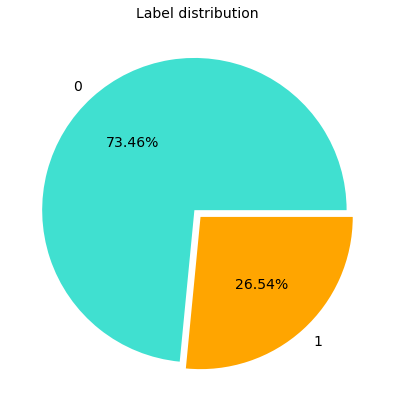

In [ ]:
## view target variable
print(clean_data['Churn'].value_counts())

pie, ax = plt.subplots(figsize=[10,7])
labels = ['0', '1']
colors = ['turquoise', 'orange']
plt.pie(x = clean_data['Churn'].value_counts()
        , autopct='%.2f%%', labels=labels, colors = colors, textprops={'fontsize': 14}, explode=[0.03]*2)
plt.title('Label distribution',fontsize=14)
plt.show()

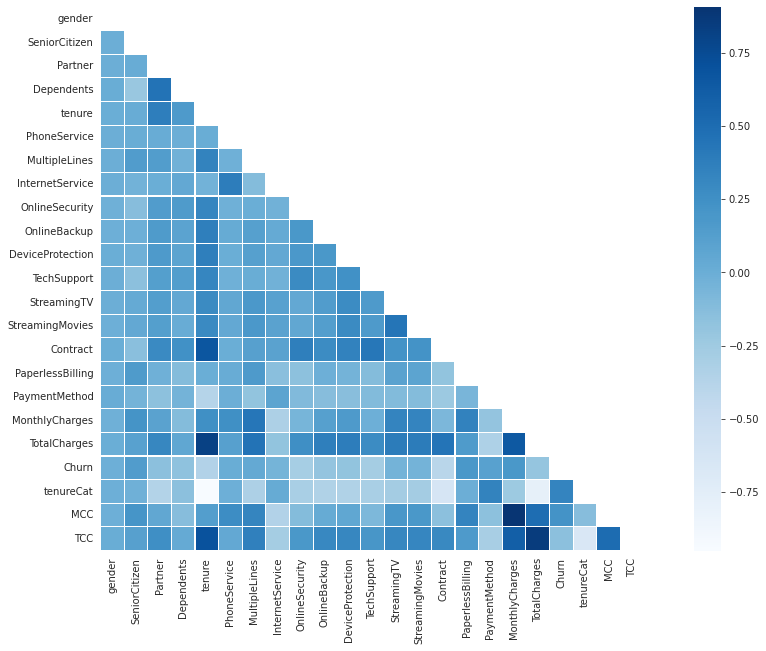

In [ ]:
## visualize the correlation 
corr = clean_data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap="Blues", center=0, linewidths=0.1, square=True)

### Clean dataset Modeling 

In [ ]:
## split the clean dataset
clean_data_train = clean_data[:int(0.8*len(clean_data))]
clean_data_test = clean_data[int(0.8*len(clean_data)):]
clean_data_train.to_csv("clean_data_train.csv")
clean_data_test.to_csv("clean_data_test.csv")

In [ ]:

clean_data_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'tenureCat', 'MCC', 'TCC'],
      dtype='object')

In [ ]:
TRAIN_CLEAN_DATASET_PATH = "/content/drive/MyDrive/clean_data_train.csv"
TEST_CLEAN_DATASET_PATH = "/content/drive/MyDrive/clean_data_test.csv"

def train_model(params, train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)

    FEATURE_COLUMNS = [ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges','tenureCat',
       'MCC', 'TCC']
    TARGET_COLUMN = ["Churn"]
    X_train, y_train = train[FEATURE_COLUMNS], train[TARGET_COLUMN]
    X_test, y_test = test[FEATURE_COLUMNS], test[TARGET_COLUMN]

    rf = RandomForestClassifier(**params)
    model = rf.fit(X_train, y_train)
    res = model.predict(X_test)

    return classification_report(y_test,res, output_dict=True)

In [ ]:
run["datasets/train"].track_files(TRAIN_CLEAN_DATASET_PATH)
run["datasets/test"].track_files(TEST_CLEAN_DATASET_PATH)

InactiveRunException: ignored

## Run model training and log parameters and metrics to Neptune

In [ ]:
params = {
    "n_estimators": 5,
    "max_depth": 2,
    "max_features": 5,
}
run["parameters"] = params

In [ ]:
score = train_model(params, TRAIN_CLEAN_DATASET_PATH, TEST_CLEAN_DATASET_PATH)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
score

{'0': {'f1-score': 0.8600896860986547,
  'precision': 0.7978369384359401,
  'recall': 0.9328793774319066,
  'support': 1028},
 '1': {'f1-score': 0.4693877551020408,
  'precision': 0.6666666666666666,
  'recall': 0.36220472440944884,
  'support': 381},
 'accuracy': 0.7785663591199432,
 'macro avg': {'f1-score': 0.6647387206003477,
  'precision': 0.7322518025513034,
  'recall': 0.6475420509206777,
  'support': 1409},
 'weighted avg': {'f1-score': 0.7544421092997122,
  'precision': 0.7623679011441779,
  'recall': 0.7785663591199432,
  'support': 1409}}

In [ ]:
run["metrics/accuracy"] = score["accuracy"]

In [ ]:
run["metrics/recall"] = score["macro avg"]["recall"]

In [ ]:
run["metrics/f1-score"] = score["macro avg"]["f1-score"]

Get the run ID of your model training from Neptune. 

In [ ]:
baseline_run_id = run["sys/id"].fetch()
print(baseline_run_id)

MLOP-48


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/mlops/mlops/e/MLOP-48
